<a href="https://colab.research.google.com/github/Carabinero/politeness-review-classification/blob/main/politeness_convencional_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install sklearn.ensemble

ERROR: Could not find a version that satisfies the requirement sklearn.ensemble (from versions: none)
ERROR: No matching distribution found for sklearn.ensemble


## 1. Definição do Problema

Trata-se do problema de classificar o tom de polidez de revisões de artigos.
O dataset possui 2500 instancias classificadas em 5 niveis de polidez mutuamente excludente (cada amostra pertence a apenas uma classe).

### 1.1 Carregamento das bibliotecas

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from string import punctuation
import re
from transformers import pipeline, AutoTokenizer, AutoModel
from gensim import utils
import gensim.models
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer,
)
from wordcloud import WordCloud
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
# from sklearn.ensemble import MetaEstimator




## 2. Preparação dos Dados
Análise e pré-processamento:

Verifique se os dados estão balanceados entre as classes. Se houver desbalanceamento, considere técnicas como oversampling (SMOTE) ou undersampling.
- Normalização ou padronização dos atributos numéricos.
- Codificação de atributos categóricos (e.g., one-hot encoding, label encoding).

Divisão dos Dados:

- Divida o conjunto de dados em treino, validação e teste (e.g., 70% treino, 15% validação, 15% teste).
Codificação das Classes:

- Use label encoding para multi-classe.
- Para multi-label, utilize multi-hot encoding.


### 2.1 Carregamento dos dados e limpeza inicial

In [5]:
df = pd.read_csv('sample_data/PolitenessDataset-FULL.csv')
print(df.shape)
df.drop(['Review ID', 'Venue', 'Review URL'], axis=1, inplace=True)
df.dropna(inplace=True)
df

(2500, 5)


,review,Tone
0,"It is early in the year, but difficult to imag...",2
1,You do not use the empirical data for the anal...,2
2,I understand that Wikipedia is not the best so...,3
3,Reviewer #1: 'The project can hardly be descri...,3
4,The figures are dishonest and not all that use...,2
...,...,...
2495,The scientific contribution of this paper - if...,2
2496,Reviewer 2: The proposal is also poorly writte...,2
2497,The paper could be considered for acceptance g...,3
2498,I don't see how your approach has potential to...,2


In [6]:
def preprocess(x: str):
    new_x = x.replace(r'"',' ')
    for c in punctuation:
        new_x = new_x.replace(c,' ')
    pattern = r"""
    [^\w\s]|         # Remove punctuation
    http\S+|         # Remove links
    @\w+|            # Remove mentions
    #\S+|            # Remove hashtags
    \b\w*\d\w*\b|    # Remove words containing numbers
    \s+              # Normalize spaces
    """
    new_x = re.sub(pattern, ' ', new_x, flags=re.VERBOSE) #removendo pontuação do texto
    return new_x.lower().strip()

df['review_pro'] = df['review'].apply(preprocess)
df = df.drop(["review"], axis=1)
df = df.rename(columns={"review_pro": "review"})
df = df.rename(columns={"Tone": "tone"})
# print(df.columns)
df

,tone,review
0,2,it is early in the year but difficult to imagi...
1,2,you do not use the empirical data for the anal...
2,3,i understand that wikipedia is not the best so...
3,3,reviewer the project can hardly be described...
4,2,the figures are dishonest and not all that useful
...,...,...
2495,2,the scientific contribution of this paper if t...
2496,2,reviewer the proposal is also poorly written...
2497,3,the paper could be considered for acceptance g...
2498,2,i don t see how your approach has potential to...


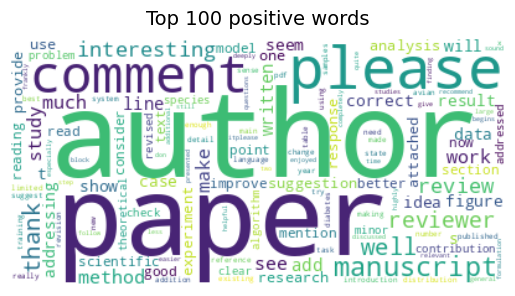

In [7]:
positive_df = df[df["tone"] == 5]["review"][:100]  # 1 = positive, 0 = negative
positive_df = reduce(lambda a, b: a + b, positive_df)

# Create and generate a word cloud image
cloud_positives = WordCloud(background_color="white").generate(positive_df)

# Display the generated wordcloud image
plt.imshow(cloud_positives, interpolation="bilinear")
plt.title("Top 100 positive words", y=1.02, size=14)  # Choose title, position and size
plt.axis("off")  # Turn off axis labels

# Show the final image
plt.show()

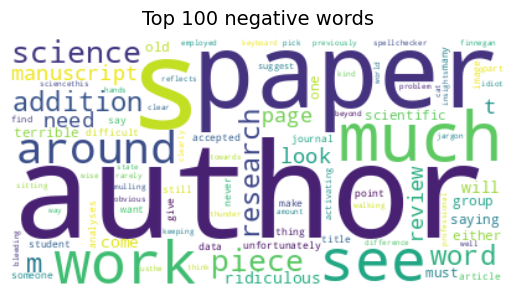

In [8]:
negative_df = df[df["tone"] == 1]["review"][:100]  # 1 = positive, 0 = negative
negative_df = reduce(lambda a, b: a + b, negative_df)

# Create and generate a word cloud image
cloud_positives = WordCloud(background_color="white").generate(negative_df)

# Display the generated wordcloud image
plt.imshow(cloud_positives, interpolation="bilinear")
plt.title("Top 100 negative words", y=1.02, size=14)  # Choose title, position and size
plt.axis("off")  # Turn off axis labels

# Show the final image
plt.show()

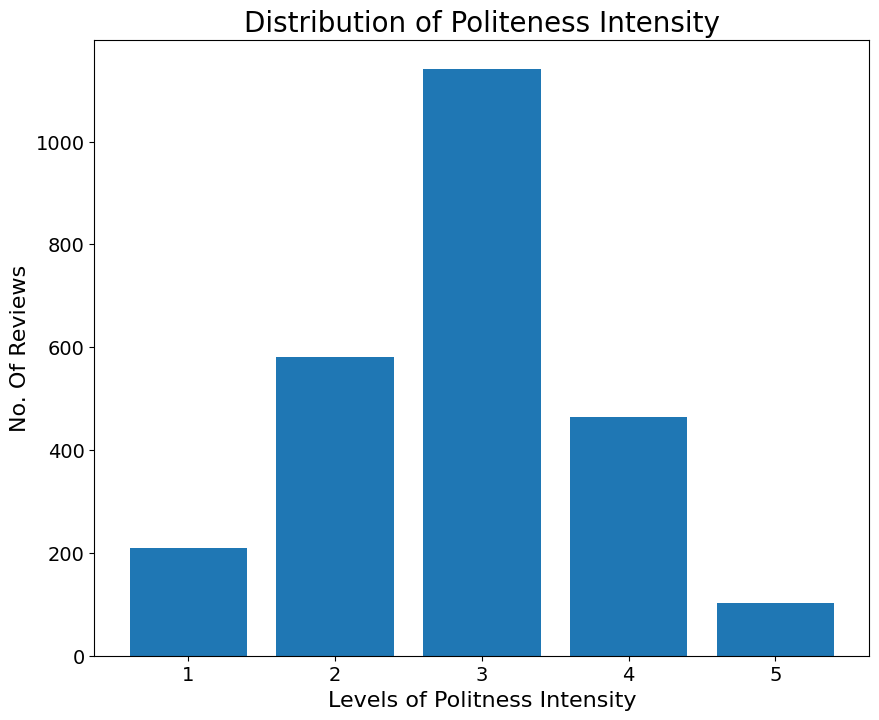

In [9]:
def plotClassDistri(df, cols):

    labels_val = dict(df[cols].value_counts())
    sorted_vals = [labels_val[key] for key in sorted(labels_val.keys())]

    fig, ax = plt.subplots(figsize=(10, 8))
    plt.bar( sorted(labels_val.keys()), sorted_vals)
    plt.title("Distribution of Politeness Intensity", fontsize=20)
    plt.xlabel("Levels of Politness Intensity",fontsize=16)
    plt.ylabel("No. Of Reviews", fontsize=16)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14, rotation=0)
    plt.show()


plotClassDistri(df,'tone')

In [10]:
df.tone.value_counts()

,count
tone,
3,1141
2,581
4,465
1,210
5,102


### 2.2 Tratando o desbalanceamento entre classes

In [11]:
def calcAvgSentLen():
    reviews = df.review.values
    len_arr = []
    for r in reviews:
        len_arr.append(len(r.split()) )

    print('\nAVG NO. OF WORDS : ',sum(len_arr)//len(len_arr))

calcAvgSentLen()


AVG NO. OF WORDS :  19


In [12]:
MAX_RECORDS_PER_CLASSS = df.tone.value_counts().max()
UNIQUE_CATEGORIES = df.tone.unique()

upsampled_df = pd.DataFrame(columns= df.columns)
for label in UNIQUE_CATEGORIES:
    df_class = df[df.tone == label]
    # print(label , ": ", df_class.shape)
    df_class = df_class.sample(MAX_RECORDS_PER_CLASSS , replace=True)
    print(label , " : ", df_class.shape)
    upsampled_df = pd.concat([upsampled_df, df_class], axis=0)

upsampled_df.reset_index(inplace=True)
upsampled_df.drop('index', axis=1, inplace=True)
print("\nFINAL UPSAMPLED DATAFRAME : " , upsampled_df.shape)

2  :  (1141, 2)
3  :  (1141, 2)
1  :  (1141, 2)
4  :  (1141, 2)
5  :  (1141, 2)

FINAL UPSAMPLED DATAFRAME :  (5705, 2)


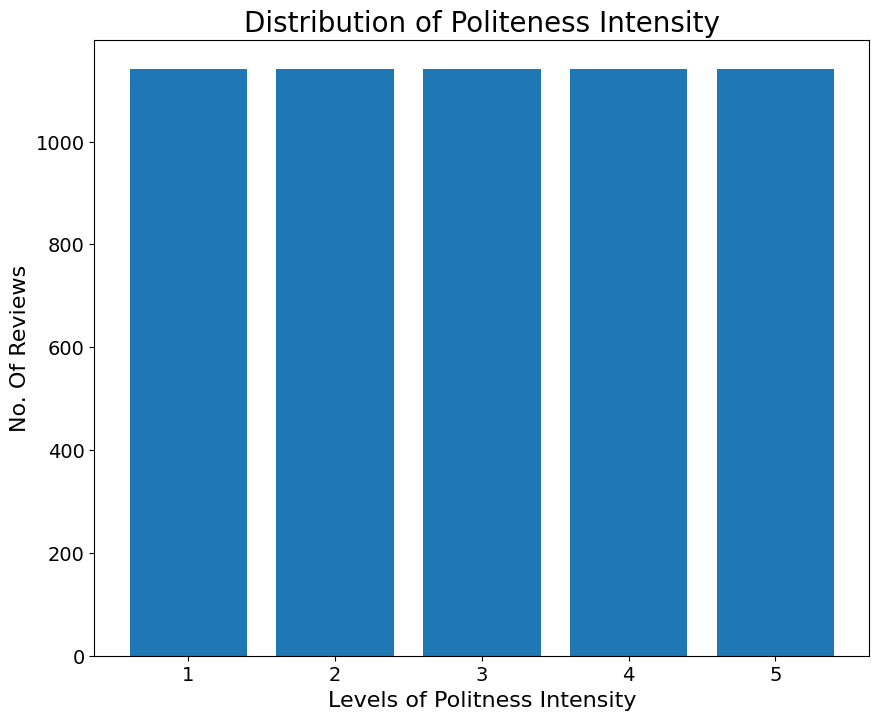

In [13]:
plotClassDistri(upsampled_df, 'tone')

### 2.3 One Hot Encoder

In [14]:
# Specify the columns you wish to one-hot encode
categorical_columns = [
    "tone"
]
upsampled_df.columns

# Perform the one-hot encoding
upsampled_df = pd.get_dummies(upsampled_df, columns=categorical_columns)

# View the resulting DataFrame
upsampled_df

,review,tone_1,tone_2,tone_3,tone_4,tone_5
0,why not do the study in vivo instead of in vitro,False,True,False,False,False
1,i do not trust the data or the underlying thesis,False,True,False,False,False
2,based on my understanding of fi lm at least th...,False,True,False,False,False
3,what do you mean by name of scientist s concep...,False,True,False,False,False
4,this lack of familiarity with the literature i...,False,True,False,False,False
...,...,...,...,...,...,...
5700,thank you for making the requested addition i ...,False,False,False,False,True
5701,thank you for your answer i have no comments t...,False,False,False,False,True
5702,thanks for addressing my concerns congrats on ...,False,False,False,False,True
5703,thanks for your rivision response paper accepted,False,False,False,False,True


### 2.4 Criando um vetorizador do texto

In [15]:
# Build the vectorizer
vect = TfidfVectorizer(
    stop_words='english',  # Default list of English stop words
    ngram_range=(1, 2),  # Consider Uni- and Bi-grams
    max_features=200,  # Max number of features
    token_pattern=r"\b[^\d\W][^\d\W]+\b",  # Capture only words using this pattern
)

vect.fit(upsampled_df.review)

# Create sparse matrix from the vectorizer
X = vect.transform(upsampled_df.review)

# Create a DataFrame
df_transformed = pd.DataFrame(data=X.toarray(), columns=vect.get_feature_names_out())
df_transformed

,abstract,accepted,actually,add,addition,additional,addressed,addressing,al,algorithm,...,unfortunately,use,used,useful,using,way,weak,work,writing,written
0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.495472,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5700,0.0,0.000000,0.0,0.000000,0.498287,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5701,0.0,0.000000,0.0,0.656866,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5702,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.654896,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.453181,0.0,0.0
5703,0.0,0.580339,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## 2.5 Separando dados de treinamento e teste

In [16]:
dropped = upsampled_df.drop(["review"], axis=1)
transformed = pd.concat([dropped, df_transformed], axis=1)
transformed


,tone_1,tone_2,tone_3,tone_4,tone_5,abstract,accepted,actually,add,addition,...,unfortunately,use,used,useful,using,way,weak,work,writing,written
0,False,True,False,False,False,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,False,True,False,False,False,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,False,True,False,False,False,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.495472,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,False,True,False,False,False,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,False,True,False,False,False,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5700,False,False,False,False,True,0.0,0.000000,0.0,0.000000,0.498287,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5701,False,False,False,False,True,0.0,0.000000,0.0,0.656866,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5702,False,False,False,False,True,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.453181,0.0,0.0
5703,False,False,False,False,True,0.0,0.580339,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [17]:
tone_cols = [col for col in transformed.columns if col.startswith("tone_")]
X = transformed.drop(columns=tone_cols, axis=1) # Drop columns starting with "tone_"
X

,abstract,accepted,actually,add,addition,additional,addressed,addressing,al,algorithm,...,unfortunately,use,used,useful,using,way,weak,work,writing,written
0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.495472,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5700,0.0,0.000000,0.0,0.000000,0.498287,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5701,0.0,0.000000,0.0,0.656866,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5702,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.654896,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.453181,0.0,0.0
5703,0.0,0.580339,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [18]:
y_5 = transformed["tone_5"].astype(int)
y_4 = transformed["tone_4"].astype(int)
y_3 = transformed["tone_3"].astype(int)
y_2 = transformed["tone_2"].astype(int)
y_1 = transformed["tone_1"].astype(int)


print(y_5.value_counts())
print(y_4.value_counts())
print(y_3.value_counts())
print(y_2.value_counts())
print(y_1.value_counts())

tone_5
0    4564
1    1141
Name: count, dtype: int64
tone_4
0    4564
1    1141
Name: count, dtype: int64
tone_3
0    4564
1    1141
Name: count, dtype: int64
tone_2
0    4564
1    1141
Name: count, dtype: int64
tone_1
0    4564
1    1141
Name: count, dtype: int64


In [19]:
# Train/test split
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(
    X,
    y_5,
    stratify=y_5,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=456,  # Random seed for reproducibility
)

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(
    X,
    y_4,
    stratify=y_4,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=456,  # Random seed for reproducibility
)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X,
    y_3,
    stratify=y_3,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=456,  # Random seed for reproducibility
)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X,
    y_2,
    stratify=y_2,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=456,  # Random seed for reproducibility
)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X,
    y_1,
    stratify=y_1,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=456,  # Random seed for reproducibility
)




## 3. Escolha do Modelo
Selecione modelos que suportam classificação multi-classe diretamente, ou implemente estratégias para transformar o problema.

Modelos que Suportam Multi-Classe Diretamente:
- Árvores de Decisão (e.g., Random Forest, Gradient Boosting, XGBoost).
- Regressão Logística Multiclasse.
- Redes Neurais.
- K-Nearest Neighbors (kNN).
- Máquinas de Vetores de Suporte (SVM) com kernel apropriado.

Estratégias para Modelos que Não Suportam Multi-Classe Nativamente:
- One-vs-Rest (OvR):
 - Treina um modelo binário para cada classe, tratando-a como "positiva" e as outras como "negativas".
- One-vs-One (OvO):
 - Treina um modelo binário para cada par de classes e utiliza votação para decidir o rótulo final.

Essas estratégias são aplicáveis, por exemplo, para SVMs e modelos lineares.



### 3.1 Avaliação dos modelos

In [155]:
from collections import defaultdict
import time

def train_and_evaluate_models(model_classes, X_train_data, X_test_data, y_train_data, y_test_data, tone_levels):
    """
    Trains specified models for each tone level and stores them in a dictionary.

    Args:
        model_classes: A list of model classes (e.g., [LogisticRegression, KNeighborsClassifier, GaussianNB]).
        X_train_data: A dictionary containing training data features for each tone level.
        X_test_data: A dictionary containing testing data features for each tone level.
        y_train_data: A dictionary containing training data labels for each tone level.
        y_test_data: A dictionary containing testing data labels for each tone level.
        tone_levels: A list of tone levels (e.g., [5, 4, 3, 2, 1]).

    Returns:
        A dictionary where keys are tone levels and values are dictionaries containing trained models.
    """
    trained_models = defaultdict(dict)  # Use defaultdict to store models for each tone level
    accuracy_results = defaultdict(dict)  # Store accuracy results
    f1_results = defaultdict(dict)  # Store F1 scores
    training_times = defaultdict(dict) # Store training times

    for tone_level in tone_levels:
        for model_class in model_classes:
            # Record start time
            start_time = time.time()

            model_name=model_class.__class__.__name__

            # Create and train the model
            model = model_class.fit(X_train_data[tone_level], y_train_data[tone_level])

            # Record end time and calculate training time
            end_time = time.time()
            training_time = end_time - start_time
            training_times[model_name][tone_level] = training_time

            # Predict the labels
            y_predicted = model.predict(X_test_data[tone_level])

            # Calculate and store accuracy
            accuracy = accuracy_score(y_test_data[tone_level], y_predicted)
            accuracy_results[model_name][tone_level] = accuracy

            # Calculate and store F1 score (macro average)
            f1 = f1_score(y_test_data[tone_level], y_predicted, average='macro')
            f1_results[model_class.model_name][tone_level] = f1

            trained_models[f"{model_name}_{tone_level}"] = model


            print(f"{model_name}_{tone_level}")
            print(model.predict_proba(X.iloc[[0],:]))
            print(model.predict(X.iloc[[0],:]))
            # Store the trained model
            trained_models[f"{model_name}_{tone_level}"] = model

    # Create the accuracy table
    accuracy_df = pd.DataFrame(accuracy_results).T  # Transpose for desired format
    accuracy_df.columns.name = "Tone Level" #set the name of the columns
    accuracy_df.index.name = "Model" #set the name of the lines

    # Create the F1 score table
    f1_df = pd.DataFrame(f1_results).T
    f1_df.columns.name = "Tone Level"
    f1_df.index.name = "Model"
    f1_df['Average'] = f1_df.mean(axis=1)

    # Create the training time table
    training_times_df = pd.DataFrame(training_times).T
    training_times_df.columns.name = "Tone Level"
    training_times_df.index.name = "Model"
    training_times_df['Average'] = training_times_df.mean(axis=1)

    # Calculate average accuracy for each model
    accuracy_df['Average Accuracy'] = accuracy_df.mean(axis=1)
    # accuracy_df['Average F1'] = f1_df.mean(axis=1)
    # accuracy_df['Average Time'] = training_times_df.mean(axis=1)
    # accuracy_df['Total Time'] = training_times_df.sum(axis=1)


    return trained_models, accuracy_df, f1_df, training_times_df

# Data dictionaries for training and testing data (assuming you have them defined)
X_train_data = {5: X_train_5, 4: X_train_4, 3: X_train_3, 2: X_train_2, 1: X_train_1}
X_test_data = {5: X_test_5, 4: X_test_4, 3: X_test_3, 2: X_test_2, 1: X_test_1}
y_train_data = {5: y_train_5, 4: y_train_4, 3: y_train_3, 2: y_train_2, 1: y_train_1}
y_test_data = {5: y_test_5, 4: y_test_4, 3: y_test_3, 2: y_test_2, 1: y_test_1}

max_iterations = 10000

# List of model classes
model_classes = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(n_neighbors=5),
    BernoulliNB(),
    MultinomialNB(),
    MLPClassifier(hidden_layer_sizes=50, solver='lbfgs', max_iter=max_iterations, random_state=42),
    RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=42),
    XGBClassifier()
]
# svm, random forest,

# List of tone levels
tone_levels = [5, 4, 3, 2, 1]

trained_models_ = defaultdict(dict)
# Train and evaluate models
trained_models_, accuracy_df, f1_df, training_times_df = train_and_evaluate_models(model_classes, X_train_data, X_test_data, y_train_data, y_test_data, tone_levels)

# Accessing trained models
# Example: Accessing the LogisticRegression model for tone level 5
# log_reg_model_tone_5 = trained_models[5]['LogisticRegression']

LogisticRegression_5
[[0.95082597 0.04917403]]
[0]
KNeighborsClassifier_5
[[1. 0.]]
[0]
BernoulliNB_5
[[0.98804016 0.01195984]]
[0]
MultinomialNB_5
[[0.91713748 0.08286252]]
[0]
MLPClassifier_5
[[1.00000000e+00 2.16695259e-12]]
[0]
RandomForestClassifier_5
[[1. 0.]]
[0]
XGBClassifier_5
[[0.98722965 0.01277033]]
[0]
LogisticRegression_4
[[0.78959131 0.21040869]]
[0]
KNeighborsClassifier_4
[[1. 0.]]
[0]
BernoulliNB_4
[[0.88886769 0.11113231]]
[0]
MultinomialNB_4
[[0.80304202 0.19695798]]
[0]
MLPClassifier_4
[[9.99999999e-01 1.16440321e-09]]
[0]
RandomForestClassifier_4
[[1. 0.]]
[0]
XGBClassifier_4
[[0.91119003 0.08880997]]
[0]
LogisticRegression_3
[[0.9480243 0.0519757]]
[0]
KNeighborsClassifier_3
[[1. 0.]]
[0]
BernoulliNB_3
[[0.93737642 0.06262358]]
[0]
MultinomialNB_3
[[0.93205037 0.06794963]]
[0]
MLPClassifier_3
[[1.00000000e+00 4.05923584e-14]]
[0]
RandomForestClassifier_3
[[1. 0.]]
[0]
XGBClassifier_3
[[0.9513076  0.04869243]]
[0]
LogisticRegression_2
[[0.70237181 0.29762819]]
[0]


In [60]:
# accuracy_df['Average Accuracy'] = accuracy_df.mean(axis=1)
# print("\nAverage Accuracy per Model:")
# accuracy_table[['Average Accuracy']] #print a table with the average accuracy
accuracy_df


Tone Level,5,4,3,2,1,Average Accuracy,Average F1,Average Time,Total Time
Model,,,,,,,,,
LogisticRegression,0.895706,0.819457,0.809816,0.804557,0.827344,0.831376,0.622874,0.045676,0.274055
KNeighborsClassifier,0.975460,0.879930,0.836985,0.830850,0.867660,0.878177,0.793081,0.009816,0.058899
BernoulliNB,0.886941,0.804557,0.786152,0.789658,0.764242,0.806310,0.658630,0.017868,0.107206
MultinomialNB,0.869413,0.813322,0.803681,0.799299,0.822086,0.821560,0.571016,0.009465,0.056788
MLPClassifier,0.990359,0.949167,0.886941,0.908852,0.937774,0.934619,0.887924,13.896814,83.380884
RandomForestClassifier,0.993865,0.960561,0.897458,0.907099,0.943032,0.940403,0.895790,1.065271,6.391629
XGBClassifier,0.994741,0.916740,0.860649,0.859772,0.922875,0.910955,0.828205,0.525629,3.153772


In [61]:
f1_df


Tone Level,5,4,3,2,1,Average
Model,,,,,,
LogisticRegression,0.805948,0.611273,0.551394,0.497364,0.648393,0.622874
KNeighborsClassifier,0.962836,0.785968,0.687609,0.709189,0.819805,0.793081
BernoulliNB,0.800929,0.648696,0.602992,0.561542,0.678991,0.658630
MultinomialNB,0.736739,0.526562,0.523392,0.456830,0.611554,0.571016
MLPClassifier,0.985049,0.919994,0.800117,0.837859,0.896601,0.887924
RandomForestClassifier,0.990424,0.935640,0.814906,0.831952,0.906028,0.895790
XGBClassifier,0.991778,0.855154,0.716216,0.710736,0.867143,0.828205


In [64]:
training_times_df["Total"] = training_times_df.sum(axis=1)
training_times_df

Tone Level,5,4,3,2,1,Average,Total
Model,,,,,,,
LogisticRegression,0.049520,0.042914,0.039401,0.052371,0.044173,0.045676,0.274055
KNeighborsClassifier,0.010212,0.008761,0.010432,0.011029,0.008649,0.009816,0.058899
BernoulliNB,0.021282,0.014565,0.015124,0.019801,0.018565,0.017868,0.107206
MultinomialNB,0.011740,0.008917,0.008969,0.009157,0.008540,0.009465,0.056788
MLPClassifier,5.376306,15.141654,21.595227,13.189874,14.181009,13.896814,83.380884
RandomForestClassifier,0.708847,0.917931,1.897754,1.014883,0.786943,1.065271,6.391629
XGBClassifier,0.414022,0.453804,0.901081,0.440415,0.418822,0.525629,3.153772


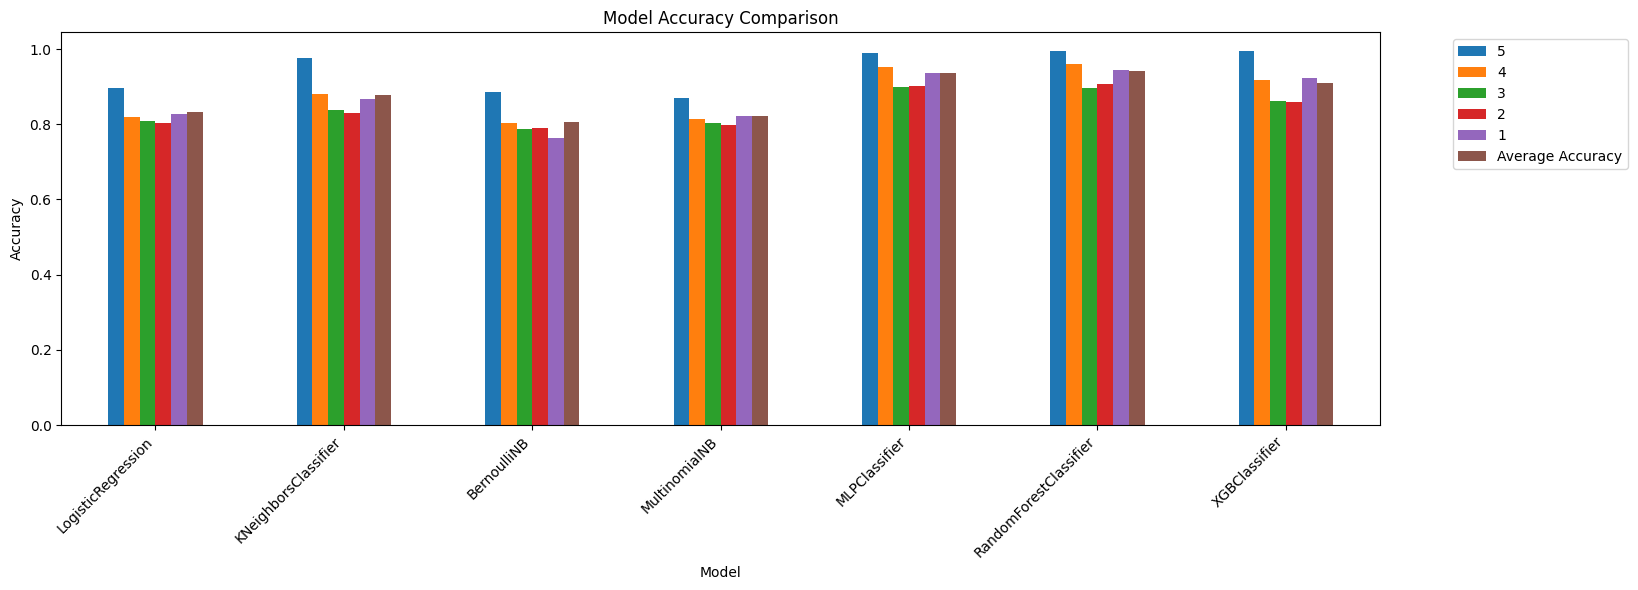

In [49]:
import matplotlib.pyplot as plt

ax = accuracy_df.plot(kind='bar', figsize=(14, 6))
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## 4. Treinamento do Modelo
Ajuste os hiperparâmetros usando validação cruzada ou conjuntos de validação.
Escolha uma função de perda adequada para multi-classe, como:
Cross-Entropy Loss (mais comum).
Categorical Hinge Loss.



## 5. Avaliação do Modelo
Use métricas apropriadas para problemas multi-classe:

Matriz de Confusão: Analisa erros entre as classes.
Acurácia: Percentual de previsões corretas.
F1-Score Macro: Média do F1-score entre classes (útil para dados desbalanceados).
AUC-ROC Multiclasse: Mede a qualidade do modelo em problemas de classificação probabilística.

In [75]:
# vect.get_feature_names_out()

from sklearn.metrics import auc
import shap

rf_model_5 = trained_models[5]['RandomForestClassifier']

med_5 = X_train_5.mean().values.reshape((1, X_train_5.shape[1]))

# Create object that can calculate shap values
explainer = shap.KernelExplainer(rf_model_5.predict_proba, med_5)

# Calculate Shap values
shap_values = explainer.shap_values(X_test_5, nsamples=len(X_train_5))

shap_values_tone_5 = shap_values[1]

shap.summary_plot(shap_values_tone_5, X_test_5, vect.get_feature_names_out(), show=False, color_bar=True,
                          max_display=10,
                          plot_size=(11, 8))

# shap.summary_plot(shap_values[1], X_test_5.iloc[0:len(X_test_5), :], vect.get_feature_names_out(), show=False, color_bar=True,max_display=10,plot_size=(11, 8))

  0%|          | 0/1141 [00:00<?, ?it/s]

KeyboardInterrupt: 

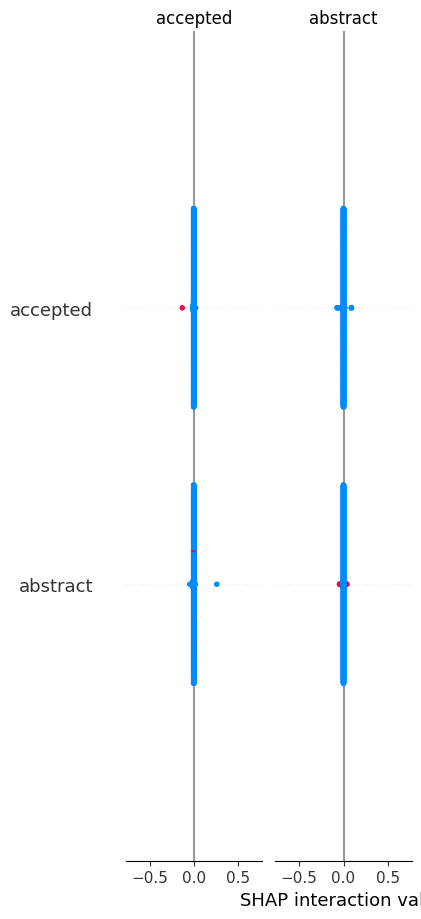

In [77]:
shap_values_tone_5 = np.load("my_3d_array.npy")

shap.summary_plot(shap_values_tone_5, X_test_5, vect.get_feature_names_out(), show=False, color_bar=True,
                          max_display=10,
                          plot_size=(11, 8))

In [74]:
import numpy as np
# Save to file
# np.save("my_3d_array.npy", shap_values)
# Load from file
loaded_array = np.load("my_3d_array.npy")
print(loaded_array)

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.00303352 -0.00303352]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.00137866 -0.00137866]]

 [[ 0.00361095 -0.00361095]
  [ 0.          0.        ]
  [-0.00180805  0.00180805]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.00502606 -0.00502606]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ...

 [[ 0.          0.        ]
  [-0.00182023  0.00182023]
  [ 0.          0.        ]
  ...
  [ 0.          0.        ]
  [ 0.00353751 -0.00353751]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ...
  [ 0.          0.      

In [81]:


# Derive feature importances
feature_importances = trained_models[5]['RandomForestClassifier'].feature_importances_

# Plot the feature importances
# plt.barh(X_train_5.columns, feature_importances)
# plt.show()

# positive_df = df[df["tone"] == 5]["review"][:100]  # 1 = positive, 0 = negative
# positive_df = reduce(lambda a, b: a + b, positive_df)

# Create and generate a word cloud image
cloud_positives = WordCloud(background_color="white").generate(feature_importances[:10])

# Display the generated wordcloud image
plt.imshow(cloud_positives, interpolation="bilinear")
plt.title("Top 10 positive words", y=1.02, size=14)  # Choose title, position and size
plt.axis("off")  # Turn off axis labels

# Show the final image
plt.show()

TypeError: cannot use a string pattern on a bytes-like object

{'paper': 0.0545168121615026, 'science': 0.04470322055455355, 'authors': 0.042486554437516436, 'author': 0.03644751049893952, 'like': 0.02892443689075728, 'kind': 0.024287802016820702, 'just': 0.02053327825927963, 'better': 0.01997359536885057, 'work': 0.01901569249766797, 'research': 0.018069462925019274, 'unclear': 0.016867427491882806, 'writing': 0.015119198528813292, 'large': 0.014750992424907098, 'language': 0.014677754383329198, 'read': 0.013734568321596417, 'think': 0.013622466849467994, 'manuscript': 0.01254774702823396, 'data': 0.012134267754714495, 'information': 0.011967109061256982, 'did': 0.011585093888649983, 'say': 0.011540521018457744, 'problem': 0.010923431595158725, 'use': 0.010858111856016858, 'results': 0.010854622511065823, 'unfortunately': 0.010719826505088898, 'difficult': 0.010624010475085672, 'believe': 0.0104467068019881, 'instead': 0.010184368987583691, 'point': 0.009911874124505449, 'distribution': 0.009884747056599856, 'addition': 0.009562395519747281, 'cle

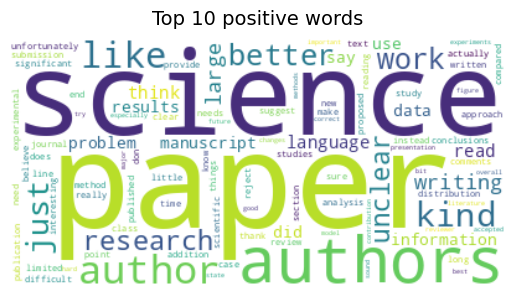

In [94]:
# Derive feature importances
feature_importances_5 = trained_models[5]['RandomForestClassifier'].feature_importances_

# Get the feature names
feature_names_5 = vect.get_feature_names_out()

# Create a dictionary mapping feature names to importances
feature_importance_dict_5 = dict(zip(feature_names_5, feature_importances_5))

# Sort the dictionary by importance in descending order and get the top 10
top_features_5 = dict(sorted(feature_importance_dict_5.items(), key=lambda item: item[1], reverse=True)[:100])
print(top_features_5)

# Create and generate a word cloud image
cloud_positives = WordCloud(background_color="white").generate_from_frequencies(top_features_5)

# Display the generated wordcloud image
plt.imshow(cloud_positives, interpolation="bilinear")
plt.title("Top 10 positive words", y=1.02, size=14)  # Choose title, position and size
plt.axis("off")  # Turn off axis labels

# Show the final image
plt.show()

{'paper': 0.0545168121615026, 'science': 0.04470322055455355, 'authors': 0.042486554437516436, 'author': 0.03644751049893952, 'like': 0.02892443689075728, 'kind': 0.024287802016820702, 'just': 0.02053327825927963, 'better': 0.01997359536885057, 'work': 0.01901569249766797, 'research': 0.018069462925019274, 'unclear': 0.016867427491882806, 'writing': 0.015119198528813292, 'large': 0.014750992424907098, 'language': 0.014677754383329198, 'read': 0.013734568321596417, 'think': 0.013622466849467994, 'manuscript': 0.01254774702823396, 'data': 0.012134267754714495, 'information': 0.011967109061256982, 'did': 0.011585093888649983, 'say': 0.011540521018457744, 'problem': 0.010923431595158725, 'use': 0.010858111856016858, 'results': 0.010854622511065823, 'unfortunately': 0.010719826505088898, 'difficult': 0.010624010475085672, 'believe': 0.0104467068019881, 'instead': 0.010184368987583691, 'point': 0.009911874124505449, 'distribution': 0.009884747056599856, 'addition': 0.009562395519747281, 'cle

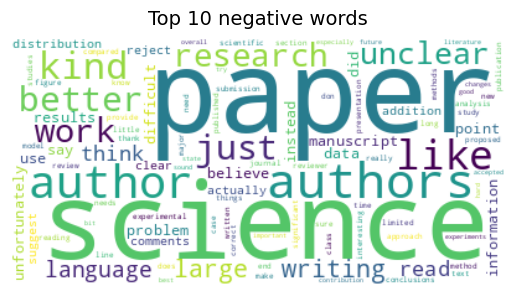

In [93]:
# Derive feature importances
feature_importances_1 = trained_models[1]['RandomForestClassifier'].feature_importances_

# Get the feature names
feature_names_1 = vect.get_feature_names_out()

# Create a dictionary mapping feature names to importances
feature_importance_dict_1 = dict(zip(feature_names_1, feature_importances_1))

# Sort the dictionary by importance in descending order and get the top 10
top_features_1 = dict(sorted(feature_importance_dict_1.items(), key=lambda item: item[1], reverse=True)[:100])
print(top_features_1)

# Create and generate a word cloud image
cloud_negatives = WordCloud(background_color="white").generate_from_frequencies(top_features_1)

# Display the generated wordcloud image
plt.imshow(cloud_negatives, interpolation="bilinear")
plt.title("Top 10 negative words", y=1.02, size=14)  # Choose title, position and size
plt.axis("off")  # Turn off axis labels

# Show the final image
plt.show()

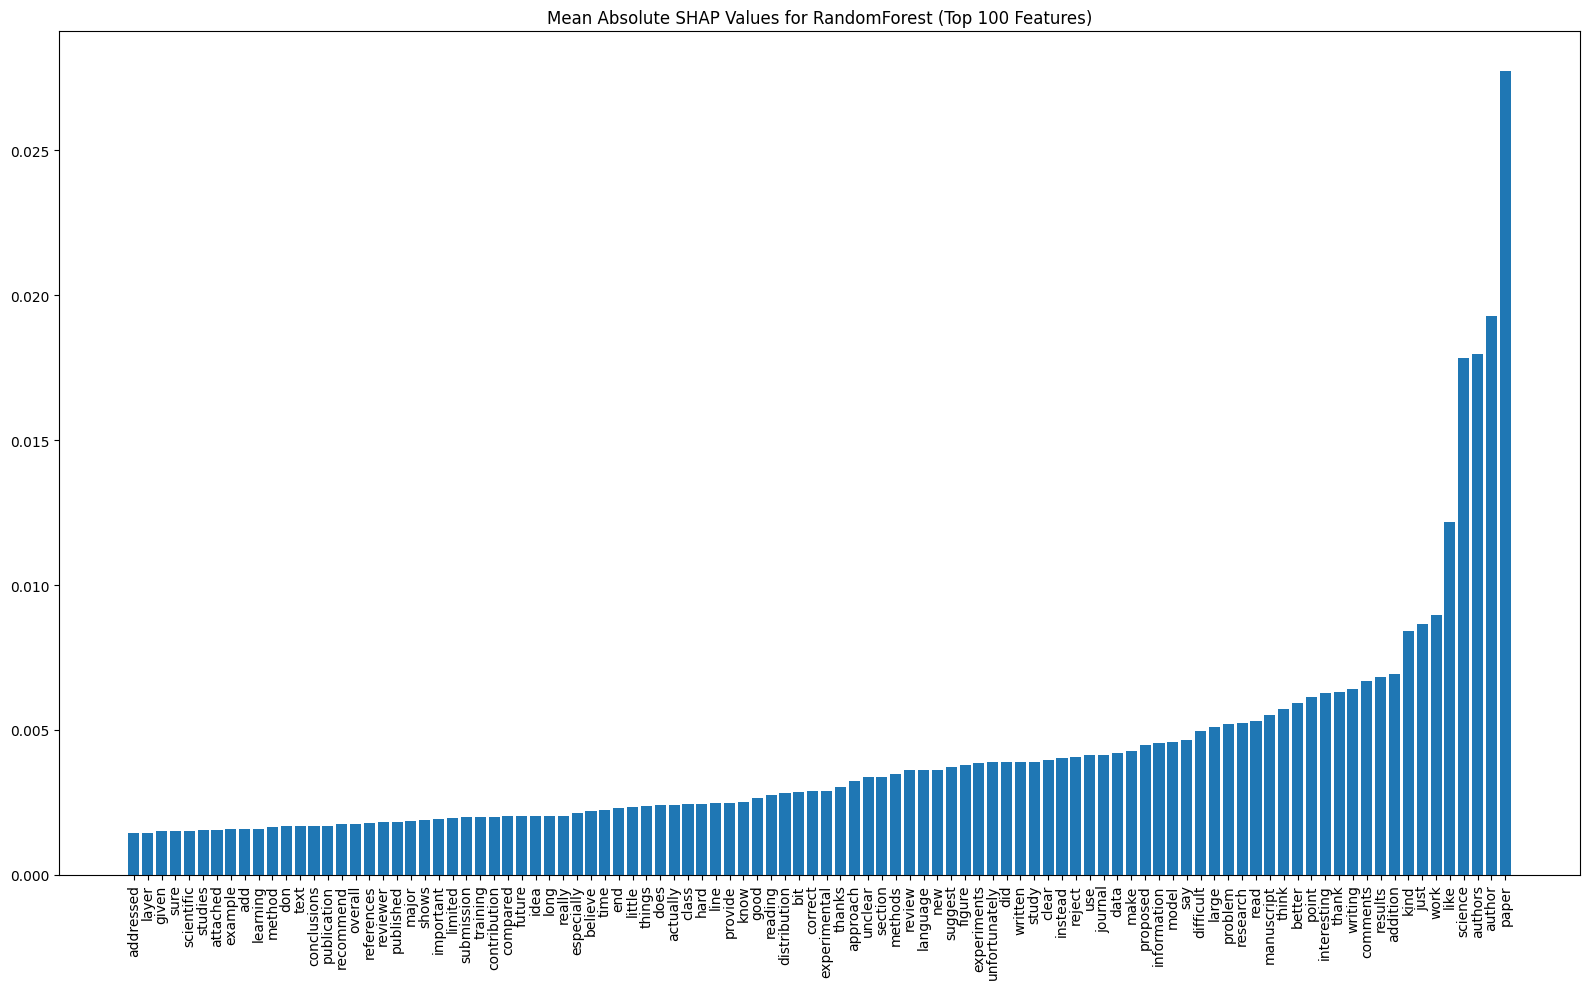

In [101]:
# Create a SHAP Tree Explainer
explainer = shap.TreeExplainer(trained_models[1]['RandomForestClassifier'])

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_1, approximate=True, check_additivity=False)

positive_values = shap_values[:,:,1]

# Calculate mean absolute SHAP values
mean_abs_shap = np.abs(shap_values[:, :, 1]).mean(axis=0)

top_100_indices = np.argsort(mean_abs_shap)[-100:]  # Indices of top 100 features

# Plot the top 100 features
plt.figure(figsize=(16, 10))
plt.bar(X.columns[top_100_indices], mean_abs_shap[top_100_indices])
plt.title('Mean Absolute SHAP Values for RandomForest (Top 100 Features)')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

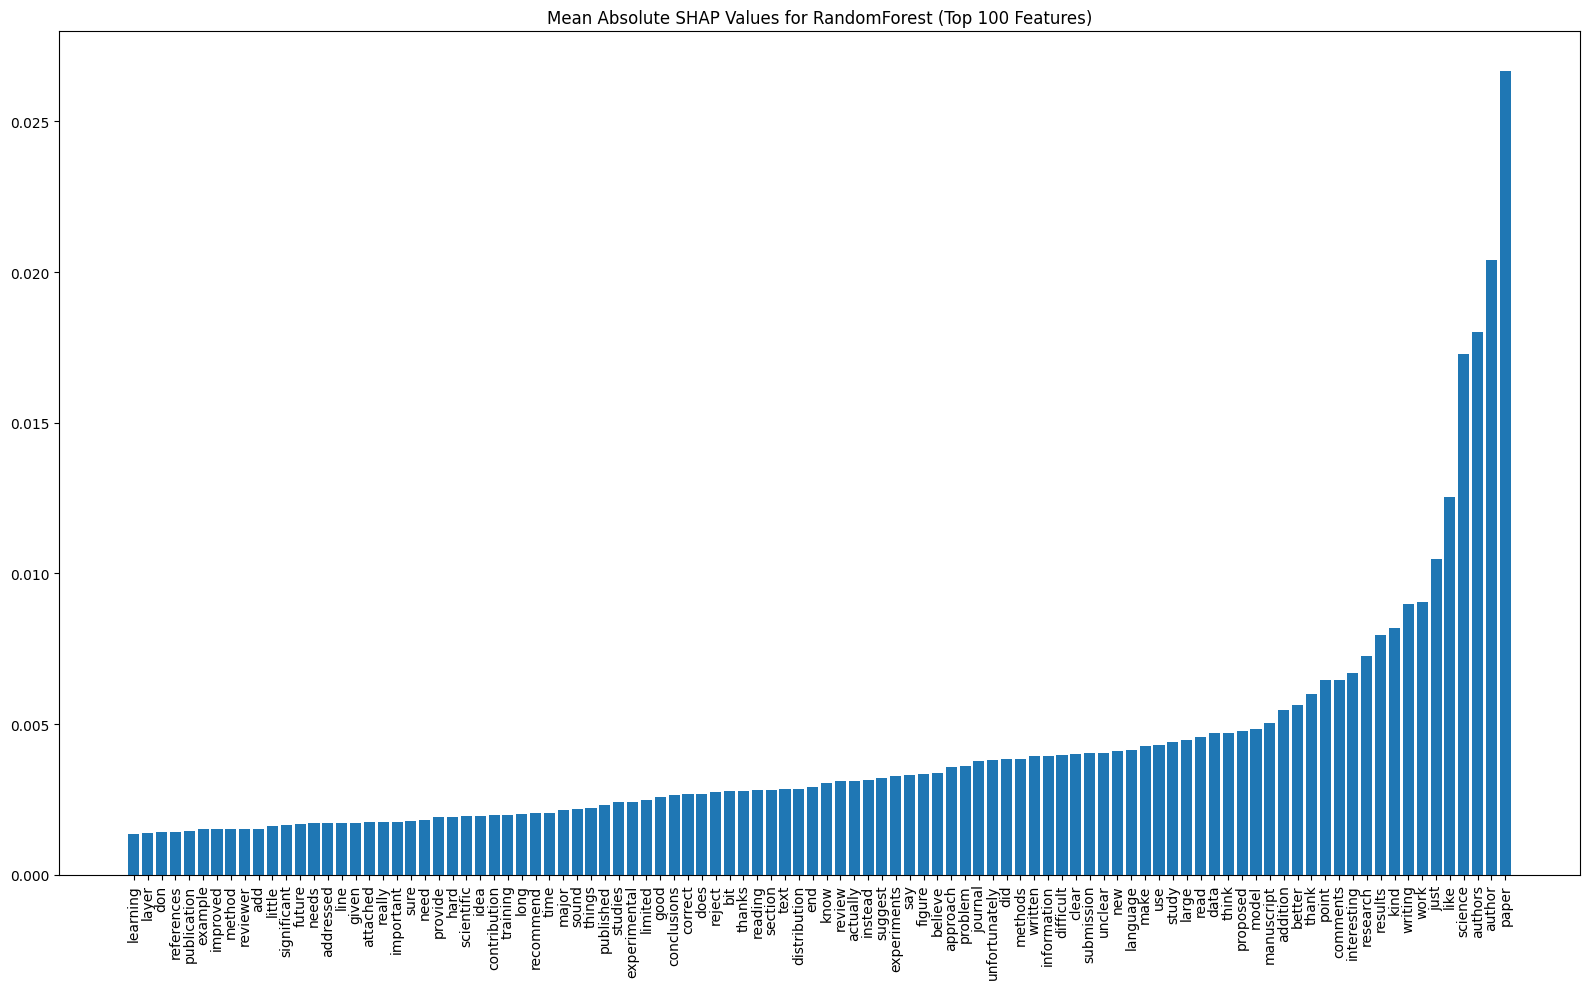

In [102]:
# Create a SHAP Tree Explainer
explainer = shap.TreeExplainer(trained_models[5]['RandomForestClassifier'])

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_5, approximate=True, check_additivity=False)

positive_values = shap_values[:,:,1]

# Calculate mean absolute SHAP values
mean_abs_shap = np.abs(shap_values[:, :, 1]).mean(axis=0)

top_100_indices = np.argsort(mean_abs_shap)[-100:]  # Indices of top 100 features

# Plot the top 100 features
plt.figure(figsize=(16, 10))
plt.bar(X.columns[top_100_indices], mean_abs_shap[top_100_indices])
plt.title('Mean Absolute SHAP Values for RandomForest (Top 100 Features)')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

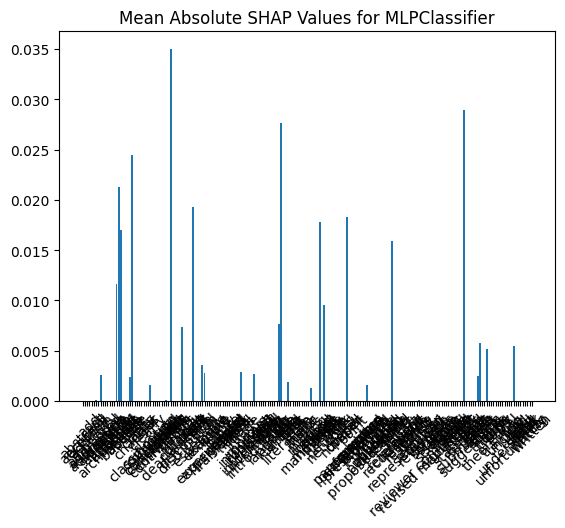

In [106]:
# Create a SHAP Kernel Explainer
explainer = shap.KernelExplainer(  trained_models[5]['RandomForestClassifier'].predict_proba,   shap.kmeans(X, 10))


# Calculate SHAP values
shap_values = explainer.shap_values(X[:10])

# Calculate mean absolute SHAP values
mean_abs_shap = np.abs(shap_values[:,:,1]).mean(axis=0)

plt.bar(X.columns, mean_abs_shap)
plt.title('Mean Absolute SHAP Values for MLPClassifier')
plt.xticks(rotation=45)
plt.show()

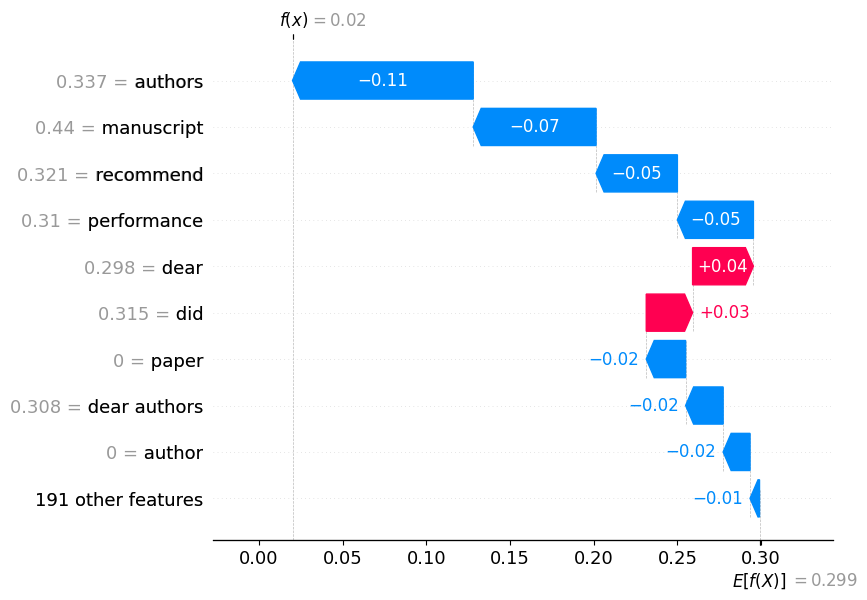

In [114]:
# explainer = shap.Explainer(trained_models[5]['RandomForestClassifier'])
# shap_values = explainer(["What a great movie! ...if you have no taste."])
# # visualize the first prediction's explanation for the POSITIVE output class
# shap.plots.text(shap_values[0, :, "POSITIVE"])

# Create the SHAP explainer
explainer = shap.KernelExplainer(trained_models[1]['RandomForestClassifier'].predict_proba, shap.kmeans(X_test_1, 10))

# Compute SHAP values for the first instance in the test dataset
shap_values = explainer.shap_values(X_test_1.iloc[10,:])

# Plot the SHAP values using a waterfall plot
shap.waterfall_plot(shap.Explanation(values=shap_values[:,1],
                    base_values=explainer.expected_value[1],
                    data=X_test_1.iloc[10,:],
                    feature_names=X.columns))

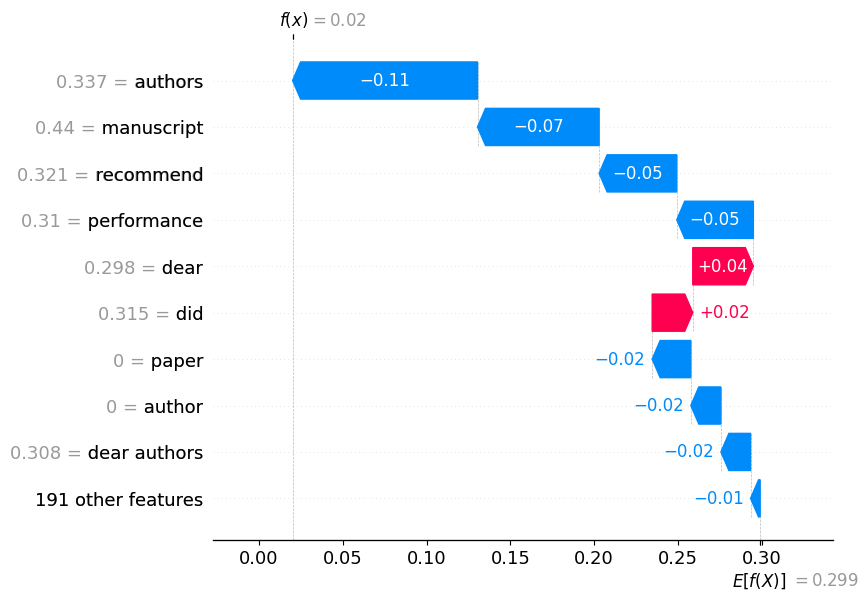

In [116]:
# Create the SHAP explainer
explainer = shap.KernelExplainer(trained_models[5]['RandomForestClassifier'].predict_proba, shap.kmeans(X_test_1, 10))

# Compute SHAP values for the first instance in the test dataset
shap_values = explainer.shap_values(X_test_1.iloc[10,:])

# Plot the SHAP values using a waterfall plot
shap.waterfall_plot(shap.Explanation(values=shap_values[:,1],
                    base_values=explainer.expected_value[1],
                    data=X_test_1.iloc[10,:],
                    feature_names=X.columns))

In [154]:
print(trained_models['RandomForestClassifier_1'].predict_proba(X.iloc[[0],:]))
print(trained_models['RandomForestClassifier_2'].predict_proba(X.iloc[[0],:]))
print(trained_models['RandomForestClassifier_3'].predict_proba(X.iloc[[0],:]))
print(trained_models['RandomForestClassifier_4'].predict_proba(X.iloc[[0],:]))
print(trained_models['RandomForestClassifier_5'].predict_proba(X.iloc[[0],:]))
print(trained_models['RandomForestClassifier_5'].predict(X.iloc[[0],:]))
X.iloc[[0],:]
upsampled_df.iloc[0,:]
# trained_models.shape

[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[0]


,0
review,why not do the study in vivo instead of in vitro
tone_1,False
tone_2,True
tone_3,False
tone_4,False
tone_5,False


In [ ]:



def shap_report(X, y):
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)

    train_X, val_X, train_y, val_y = train_test_split(X, y.values.ravel(), random_state=1)

    for a in range(len(models)):
        model = models[a]
        model_name = determine_model_name(model)

        model.fit(train_X, train_y)
        med = train_X.mean().values.reshape((1, train_X.shape[1]))

        # Create object that can calculate shap values
        explainer = shap.KernelExplainer(model.predict_proba, med)
        # Calculate Shap values
        shap_values = explainer.shap_values(val_X.iloc[0:len(train_X), :], nsamples=len(train_X))

        shap.summary_plot(shap_values[1], val_X.iloc[0:len(train_X), :], formatted_dictionary, show=False, color_bar=True,
                          max_display=10,
                          plot_size=(11, 8))

        plt.close()

def roc_curve_report(X, y):
    for a in range(len(models)):
        model = models[a]
        model_name = determine_model_name(model)
        try:
            tprs = []
            aucs = []
            mean_fpr = np.linspace(0, 1, 100)
            i = 0
            fig, ax = plt.subplots()
            for i, (train, test) in enumerate(cv.split(X, y)):
                model.fit(X[train], y[train])
                viz = plot_roc_curve(model, X[test], y[test],
                                     name='ROC fold {}'.format(i),
                                     alpha=0.3, lw=1, ax=ax)
                interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                aucs.append(viz.roc_auc)

            ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                    label='Chance', alpha=.8)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color='b',
                    label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                            label=r'$\pm$ 1 std. dev.')

            ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
                   title=model_name)
            ax.legend(loc="lower right")
            plt.savefig(
                "../results/plots/test/roc_%s_%0i_features_%0i_test.pdf" % (
                    model_name, feature_size, len(X)),
                dpi=100, facecolor='w', edgecolor='b', orientation='portrait', transparent=False, bbox_inches=None,
                pad_inches=0.1)
            print("Created %s ROC figure" % model_name)
            plt.close()
        except (AttributeError, OverflowError) as detail:
            print(model_name + " Failed due to ", detail)